In [5]:
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time
import pyccl as ccl
import sacc
import pandas as pd
import os

## Loading Data from SACC

In [53]:
import numpy as np
import sacc
import pandas as pd
import os

# Load SACC catalog
sacc_file = sacc.Sacc.load_fits(
    "/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/"
    "outputs-full-2026/cluster_sacc_catalog.sacc"
)
#print(sacc_file.data)
# Define richness bin labels
rich_bin_label = ["20-35", "35-70", "70-100", "100-200"]
z_bin_label = ["0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8"]

# Extract redshift bins from tracers
Z_bins = []
z_keys = sorted([k for k in sacc_file.tracers.keys() if 'bin_z' in k])
for k in z_keys:
    tracer = sacc_file.tracers[k]
    Z_bins.append([tracer.lower, tracer.upper])
Z_bins = np.array(Z_bins)

# Extract richness bins
Rich_bins = []
r_keys = sorted([k for k in sacc_file.tracers.keys() if 'bin_rich' in k])
for k in r_keys:
    tracer = sacc_file.tracers[k]
    Rich_bins.append([tracer.lower, tracer.upper])
Rich_bins = np.array(Rich_bins)

# Extract radius bin centers
Radius_bins = []
radius_keys = sorted([k for k in sacc_file.tracers.keys() if 'radius' in k])
for k in radius_keys:
    tracer = sacc_file.tracers[k]
    Radius_bins.append(tracer.center)
Radius_bins = np.array(Radius_bins)

print("Redshift bins:", Z_bins)
print("Richness bins:", Rich_bins)
print("Radius centers:", Radius_bins)

# Save bins to text
np.savetxt("bins_redshift.txt", Z_bins, header="z_low z_high")
np.savetxt("bins_richness.txt", Rich_bins, header="rich_low rich_high")
np.savetxt("bins_radius.txt", Radius_bins, header="radius_center [Mpc]")

n_z = len(Z_bins)
n_r = len(Rich_bins)

counts_data = np.zeros((n_z, n_r))

for z_idx in range(n_z):
    for r_idx in range(n_r):
        trac_counts = ('cosmodc2_redmapper',
                       f'bin_rich_{r_idx}',
                       f'bin_z_{z_idx}')

        val_counts = sacc_file.get_data_points(
            sacc.data_types.standard_types.cluster_counts,
            trac_counts
        )[0].value

        counts_data[z_idx, r_idx] = val_counts

print("Counts from SACC:")
print(counts_data)

n_z = len(Z_bins)
n_r = len(Rich_bins)
n_rad = len(Radius_bins)

shear_data = np.zeros((n_z, n_r, n_rad))

for i in range(n_z):
    for j in range(n_r):
        for k in range(n_rad):

            trac = (
                'cosmodc2_redmapper',
                f'bin_rich_{j}',
                f'bin_z_{i}',
                f'radius_{k}'
            )

            val = sacc_file.get_data_points(
                sacc.data_types.standard_types.cluster_delta_sigma,
                trac
            )[0].value

            shear_data[i, j, k] = val

print("Shear data shape:", shear_data.shape)
print(radius_keys)
print(Radius_bins)


Redshift bins: [[0.2 0.3]
 [0.3 0.4]
 [0.4 0.5]
 [0.5 0.6]
 [0.6 0.7]
 [0.7 0.8]]
Richness bins: [[1.30103    1.54406804]
 [1.54406804 1.84509804]
 [1.84509804 2.        ]
 [2.         2.30103   ]]
Radius centers: [1.20639049 1.43371343 1.70350097 2.02412462 2.40543472 2.85849195
 3.39678734]
Counts from SACC:
[[142.  73.  14.   6.]
 [255. 104.  13.   6.]
 [305. 137.  17.  17.]
 [362. 122.  19.  12.]
 [377. 153.  31.  14.]
 [312. 139.  21.   7.]]
Shear data shape: (6, 4, 7)
[np.str_('radius_0'), np.str_('radius_1'), np.str_('radius_2'), np.str_('radius_3'), np.str_('radius_4'), np.str_('radius_5'), np.str_('radius_6')]
[1.20639049 1.43371343 1.70350097 2.02412462 2.40543472 2.85849195
 3.39678734]


## Computing Mean Halo Concentration

cat1_id,cat1_z,cat1_ra,cat1_dec,cat1_richness,cat1_richness_err,cat1_id_cg,cat1_ztrue_cg,cat1_p_cg_0,cat1_mt_self,cat1_mt_other,cat1_mt_multi_self,cat1_mt_multi_other,cat1_mt_frac_self,cat1_mt_frac_other,cat1_mt_cross,cat1_mt_frac,cat2_id,cat2_z,cat2_ra,cat2_dec,cat2_mass_fof,cat2_M200c,cat2_skysim_halo_id,cat2_mt_self,cat2_mt_other,cat2_mt_multi_self,cat2_mt_multi_other,cat2_mt_frac_other,cat2_mt_frac_self,cat2_mt_cross,cat2_mt_frac
bytes11,float32,float64,float64,float32,float32,int64,float32,float32,bytes13,bytes13,bytes150,bytes150,float64,float64,bytes13,float64,bytes21,float64,float64,float64,float64,float64,float64,bytes6,bytes6,bytes31,bytes31,float64,float64,bytes6,float64
10,0.5135129,52.520436430812914,-25.717996124671657,190.70665,3.7469666,1312945563,0.51072353,0.79138356,1162500021323,1162500021323,"1162500021323,922700021315,205900021323,417800021323,665600021315,1361100021315,711400021315,80500021323","80500021323,922700021315,205900021323,417800021323,665600021315,1361100021315,711400021315,1162500021323",0.4496726208984491,0.30094043887147337,1162500021323,0.4496726208984491,1162500021323,0.5107235191306336,52.520436430812914,-25.717996124671657,546154289100078.9,326491145207346.5,1156008787323.0,10,10,10,10,0.4496726208984491,0.30094043887147337,10,0.30094043887147337
18,0.5712697,56.920376528125075,-27.20434071042304,179.12813,3.6934361,2000524808,0.5740297,0.99996513,549500032315,549500032315,549500032315,549500032315,0.9421648861882373,0.35064935064935066,549500032315,0.9421648861882373,549500032315,0.5740296938561777,56.920376528125075,-27.20434071042304,1009535371108236.6,645749230889104.2,158908916315.0,18,18,18,18,0.9421648861882373,0.35064935064935066,18,0.35064935064935066
24,1.040338,56.99849698116052,-26.7172081871169,124.02715,2.4172914,2002535198,1.0347759,0.93527913,2554900032241,2554900032241,"2554900032241,1212700032259,3011300032241","2554900032241,1212700032259,3011300032241",0.9468829847683286,0.28444444444444444,2554900032241,0.9468829847683286,2554900032241,1.034775804769664,56.99849698116052,-26.7172081871169,381884526534309.9,383668275413453.56,3667408916241.0,24,24,24,24,0.9468829847683286,0.28444444444444444,24,0.28444444444444444
30,0.63518524,58.56362402841767,-27.429961828331713,167.33603,3.6777163,2000759779,0.6426174,0.9958548,1275900032300,1275900032300,"6600032300,1275900032300,23400032300","6600032300,1275900032300,23400032300",0.9812835255072209,0.2767857142857143,1275900032300,0.9812835255072209,1275900032300,0.6426174147729209,58.56362402841767,-27.429961828331713,388491914052507.06,216337687012597.2,1087308916300.0,30,30,30,30,0.9812835255072209,0.2767857142857143,30,0.2767857142857143
71,0.44230303,58.35519782866568,-26.867687128773035,111.9147,3.366554,2000289335,0.43919736,0.7297119,564000032338,564000032338,"161400032338,359200032338,731900032338,564000032338,778100032338,243000032347","161400032338,359200032338,731900032338,564000032338,778100032338,243000032347",0.5346957617359577,0.2518518518518518,564000032338,0.5346957617359577,564000032338,0.4385807111345399,58.34992458608299,-26.866270557202213,356926172895549.3,322972230485814.1,252508916338.0,71,71,71,71,0.5346957617359577,0.2518518518518518,71,0.2518518518518518
73,0.46697217,57.76575707007693,-28.119101936484828,104.439766,2.9570596,2000290819,0.4680865,0.99970347,459400032338,459400032338,"2200032331,459400032338,980800032331","2200032331,459400032338,980800032331",0.9046435837281485,0.2780612244897959,459400032338,0.9046435837281485,459400032338,0.4680865186324199,57.76575707007693,-28.119101936484828,358202422805633.8,278007164916462.0,175708916338.0,73,73,"73,4848","73,4848",0.9046435837281485,0.2780612244897959,73,0.2780612244897959
109,0.4413634,58.509466974185045,-26.989676182075844,103.49396,3.3524604,2000286447,0.44349608,0.99999905,156700032338,156700032338,"156700032338,433200032355","156700032338,433200032355",0.9589822433529834,0.28672985781990523,156700032338,0.9589822433529834,156700032338,0.

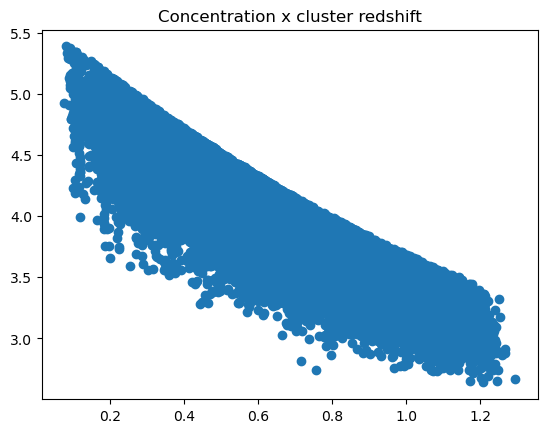

The median concentration is 3.7995857877477124


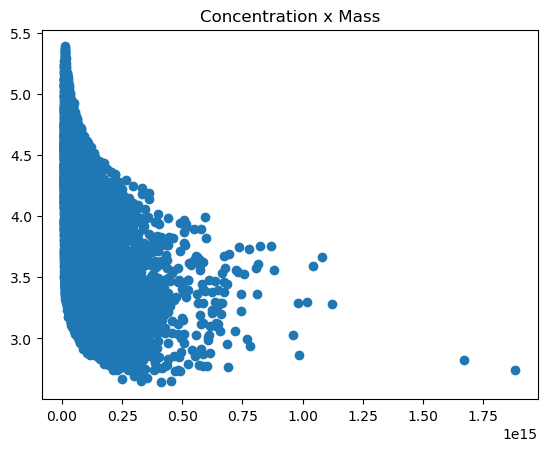

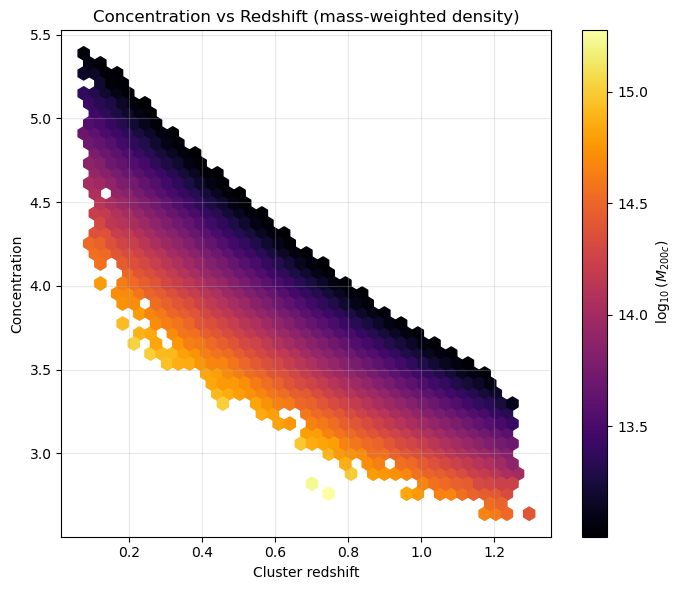

In [60]:
from astropy.table import Table
index = 12
suff = '_full_coverage'
path_to_data = '/sps/lsst/users/ebarroso/CLCosmo_Sim_database/data/'
t_cl_halo_match = Table.read(path_to_data + "matched_pairs_Mfofcut.fits")
cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)
display(t_cl_halo_match)
conc_list = []
t_cl_halo_conc = t_cl_halo_match[t_cl_halo_match["cat2_M200c"] > 1e12]
conc_model = ccl.halos.concentration.ConcentrationBhattacharya13(mass_def='200c')
for line in t_cl_halo_conc:
    conc_list.append(conc_model(cosmo, line["cat2_M200c"], 1.0 / (1.0 + float(line["cat1_ztrue_cg"]))))
plt.scatter(t_cl_halo_conc["cat1_ztrue_cg"], conc_list)

plt.title("Concentration x cluster redshift")
plt.show()
plt.scatter(t_cl_halo_conc["cat2_M200c"], conc_list)
plt.title("Concentration x Mass")
print(f"The median concentration is {np.median(conc_list)}")
cluster_concentration = np.median(conc_list)


z = np.array(t_cl_halo_conc["cat1_ztrue_cg"])
c = np.array(conc_list)
m = np.array(t_cl_halo_conc["cat2_M200c"])

logm = np.log10(m)

plt.figure(figsize=(7,6))

hb = plt.hexbin(
    z,
    c,
    C=logm,
    reduce_C_function=np.mean,   # mean log-mass per bin
    gridsize=40,
    cmap='inferno'
)

cbar = plt.colorbar(hb)
cbar.set_label(r" $\log_{10}(M_{200c})$")

plt.xlabel("Cluster redshift")
plt.ylabel("Concentration")
plt.title("Concentration vs Redshift (mass-weighted density)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Prediction

In [43]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.interpolate import interp1d

from crow import ClusterShearProfile
from crow import ClusterAbundance
from crow.recipes.binned_exact import ExactBinnedClusterRecipe
from crow.recipes.binned_grid import GridBinnedClusterRecipe
from crow import completeness_models, mass_proxy, purity_models, kernel
from crow.properties import ClusterProperty


mass_richness_unb = mass_proxy.MurataUnbinned(pivot_log_mass=14.3, pivot_redshift=0.5)
mass_richness_unb.parameters["mu0"] = 3.35518603 
mass_richness_unb.parameters["mu1"] = 1.02354896
mass_richness_unb.parameters["mu2"] = 0.0372352072
mass_richness_unb.parameters["sigma0"] = 0.540096860
mass_richness_unb.parameters["sigma1"] = 0.0
mass_richness_unb.parameters["sigma2"] = 0.0
hmf = ccl.halos.MassFuncDespali16(mass_def="200c")

cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)

mass_grid_size = 80
redshift_grid_size = 40
proxy_grid_size = 40
sky_area = 440
mass_interval = (12.5, 15.5)


cl_abundandce = ClusterAbundance(cosmo, hmf)
purity_aguena = purity_models.PurityAguena16()
completeness_aguena = completeness_models.CompletenessAguena16()
cl_delta_sigma = ClusterShearProfile(
    cosmo, hmf, is_delta_sigma=True, cluster_concentration=cluster_concentration
)
redshift_distribution = kernel.SpectroscopicRedshift()

Counts Data: [[142.  73.  14.   6.]
 [255. 104.  13.   6.]
 [305. 137.  17.  17.]
 [362. 122.  19.  12.]
 [377. 153.  31.  14.]
 [312. 139.  21.   7.]]
Counts Prediction: [[133.04560616  65.990994    12.63691135   8.50709126]
 [209.30247035 100.30181201  18.34955421  11.80300667]
 [272.03019762 125.6378672   21.87747268  13.40346647]
 [312.75417311 138.94726184  22.9569111   13.36177841]
 [329.28604477 140.52953438  21.97048778  12.12278487]
 [323.94485217 132.69192031  19.5858161   10.22782758]]


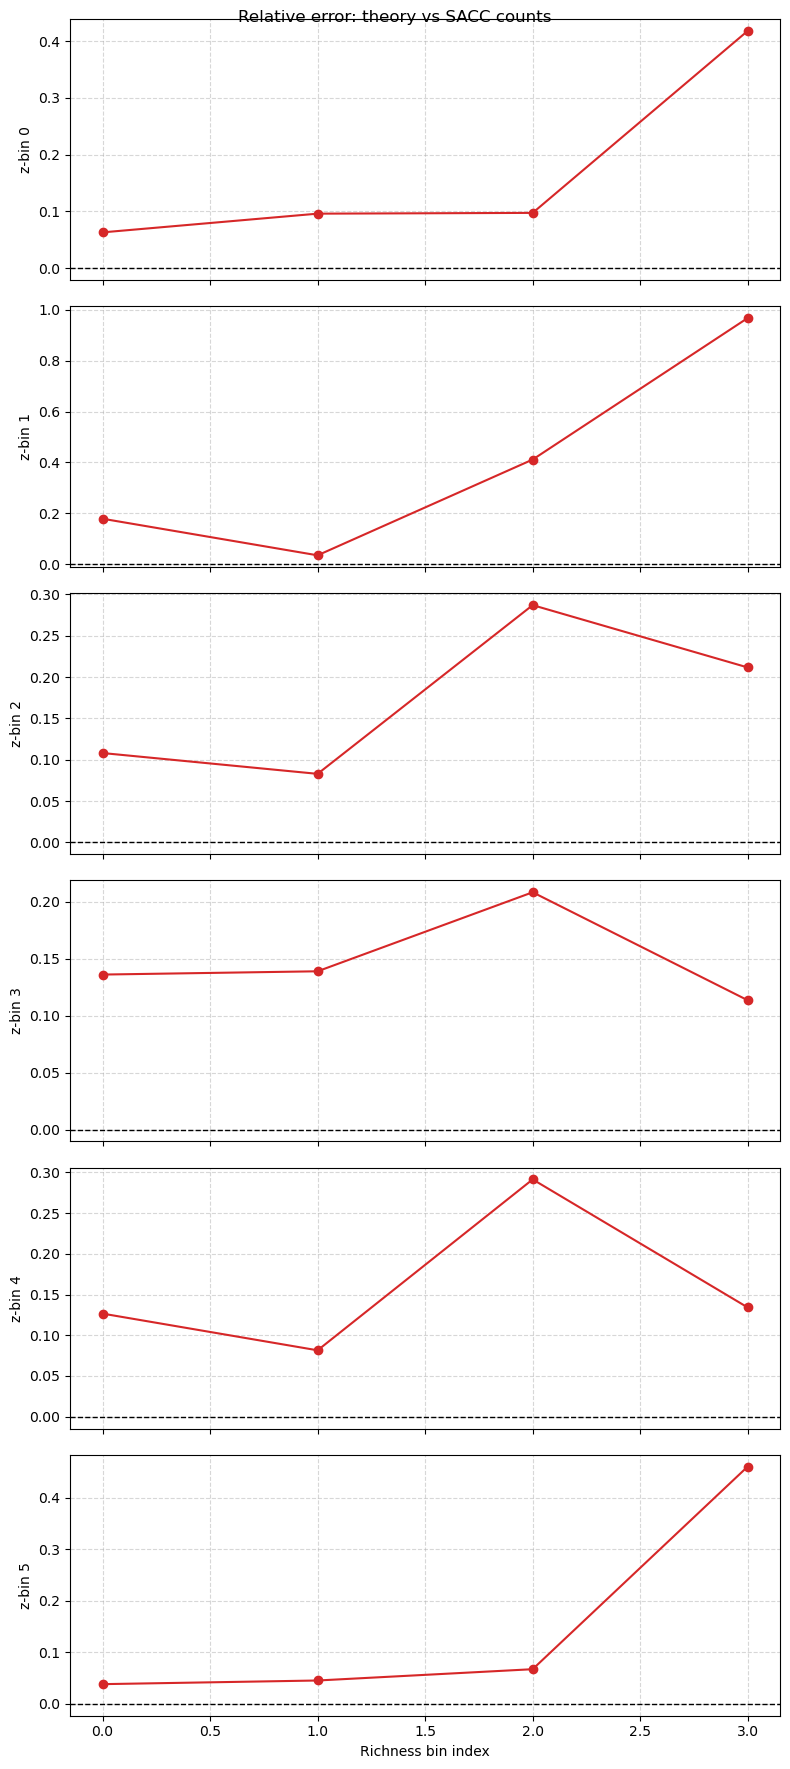

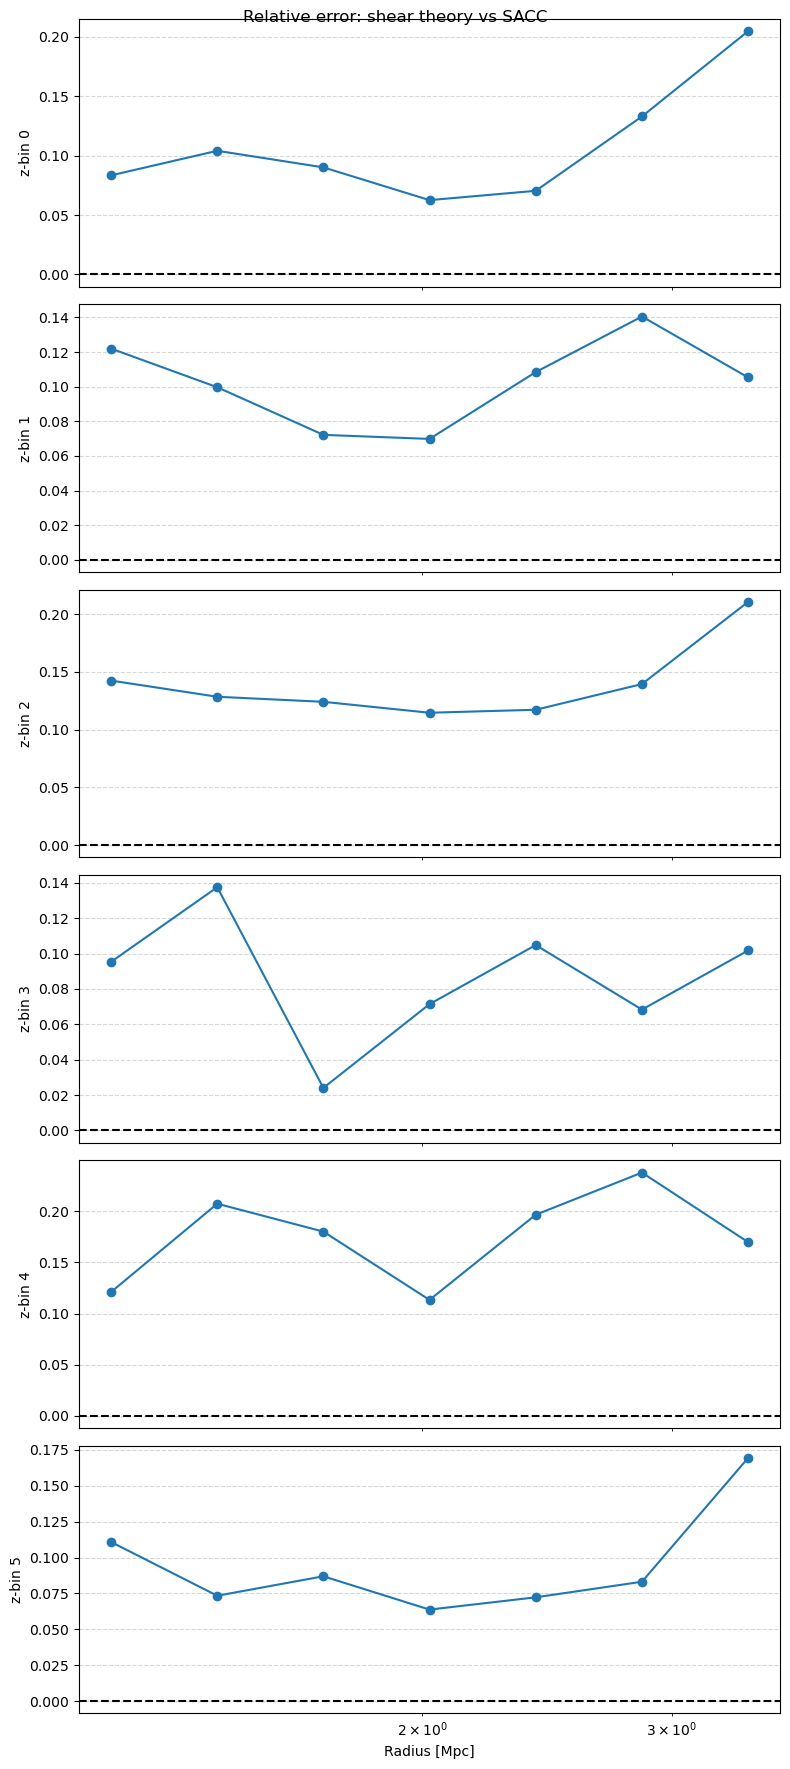

Shear Data: [[[3.21950339e+13 2.49631226e+13 2.09144418e+13 1.62333371e+13
   1.22397859e+13 8.47710419e+12 5.87419316e+12]
  [4.45741258e+13 3.66272983e+13 3.11713482e+13 2.40869569e+13
   2.03832686e+13 1.53023535e+13 1.16086070e+13]
  [6.04193692e+13 4.71539458e+13 3.80309525e+13 2.84853559e+13
   2.19963395e+13 1.60829428e+13 1.15419638e+13]
  [6.38745982e+13 4.70821175e+13 4.39458870e+13 4.26842019e+13
   3.35708275e+13 2.86600963e+13 2.39869246e+13]]

 [[2.71165550e+13 2.49686043e+13 1.85025089e+13 1.42535242e+13
   1.11889199e+13 9.58279714e+12 7.28331771e+12]
  [3.67189731e+13 3.61147490e+13 2.83893002e+13 2.11709928e+13
   1.80955508e+13 1.35281001e+13 1.03381922e+13]
  [5.40738791e+13 5.39228642e+13 4.34642083e+13 3.53391934e+13
   3.31544803e+13 2.69498583e+13 1.71420475e+13]
  [8.63384875e+13 8.10240929e+13 5.85860550e+13 4.20729977e+13
   3.71756453e+13 3.56771669e+13 2.78051813e+13]]

 [[2.70641821e+13 2.26028724e+13 2.06814099e+13 1.55101664e+13
   1.17667176e+13 8.99157

In [47]:
recipe_grid_abundance = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_richness_unb,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
    purity=purity_aguena,
    completeness=completeness_aguena
)

recipe_grid_shear = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_delta_sigma,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_richness_unb,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
    purity=None,
    completeness=completeness_aguena
)

recipe_grid_abundance.setup()
recipe_grid_shear.setup()

grid_counts_vals  = np.zeros((len(Z_bins), len(Rich_bins)))
grid_shear_vals  = np.zeros((len(Z_bins), len(Rich_bins), len(Radius_bins)))
grid_shear_error  = np.zeros((len(Z_bins), len(Rich_bins), len(Radius_bins)))
for i, zb in enumerate(Z_bins):
    for j, pb in enumerate(Rich_bins):
        val_counts = recipe_grid_abundance.evaluate_theory_prediction_counts(np.array(zb), np.array(pb), sky_area)
        grid_counts_vals[i,j] = val_counts
        shear_vals = recipe_grid_shear.evaluate_theory_prediction_lensing_profile(np.array(zb), np.array(pb), np.array(Radius_bins), sky_area, ClusterProperty.DELTASIGMA) / val_counts
        grid_shear_vals[i,j, :] = shear_vals
        grid_shear_error[i, j, :] = abs(1.0 - shear_vals / shear_data[i, j, :])

rel_error_matrix = np.abs(1 - grid_counts_vals / counts_data)

n_i, n_j = rel_error_matrix.shape

fig, axes = plt.subplots(n_i, 1, figsize=(8, 3*n_i), sharex=True)

if n_i == 1:
    axes = [axes]

for i in range(n_i):
    axes[i].plot(
        np.arange(n_j),
        rel_error_matrix[i],
        marker='o',
        linestyle='-',
        color='tab:red'
    )

    axes[i].axhline(0, color='k', linestyle='--', lw=1)
    axes[i].set_ylabel(f"z-bin {i}")
    axes[i].grid(True, ls="--", alpha=0.5)

axes[-1].set_xlabel("Richness bin index")
plt.suptitle("Relative error: theory vs SACC counts")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_z, 1, figsize=(8, 3*n_z), sharex=True)

if n_z == 1:
    axes = [axes]

for i in range(n_z):

    # average over richness
    rel_mean = grid_shear_error[i].mean(axis=0)

    axes[i].plot(
        Radius_bins,
        rel_mean,
        marker='o'
    )

    axes[i].set_xscale('log')
    axes[i].axhline(0, color='k', ls='--')
    axes[i].set_ylabel(f"z-bin {i}")
    axes[i].grid(True, ls="--", alpha=0.5)

axes[-1].set_xlabel("Radius [Mpc]")
plt.suptitle("Relative error: shear theory vs SACC")
plt.tight_layout()
plt.show()

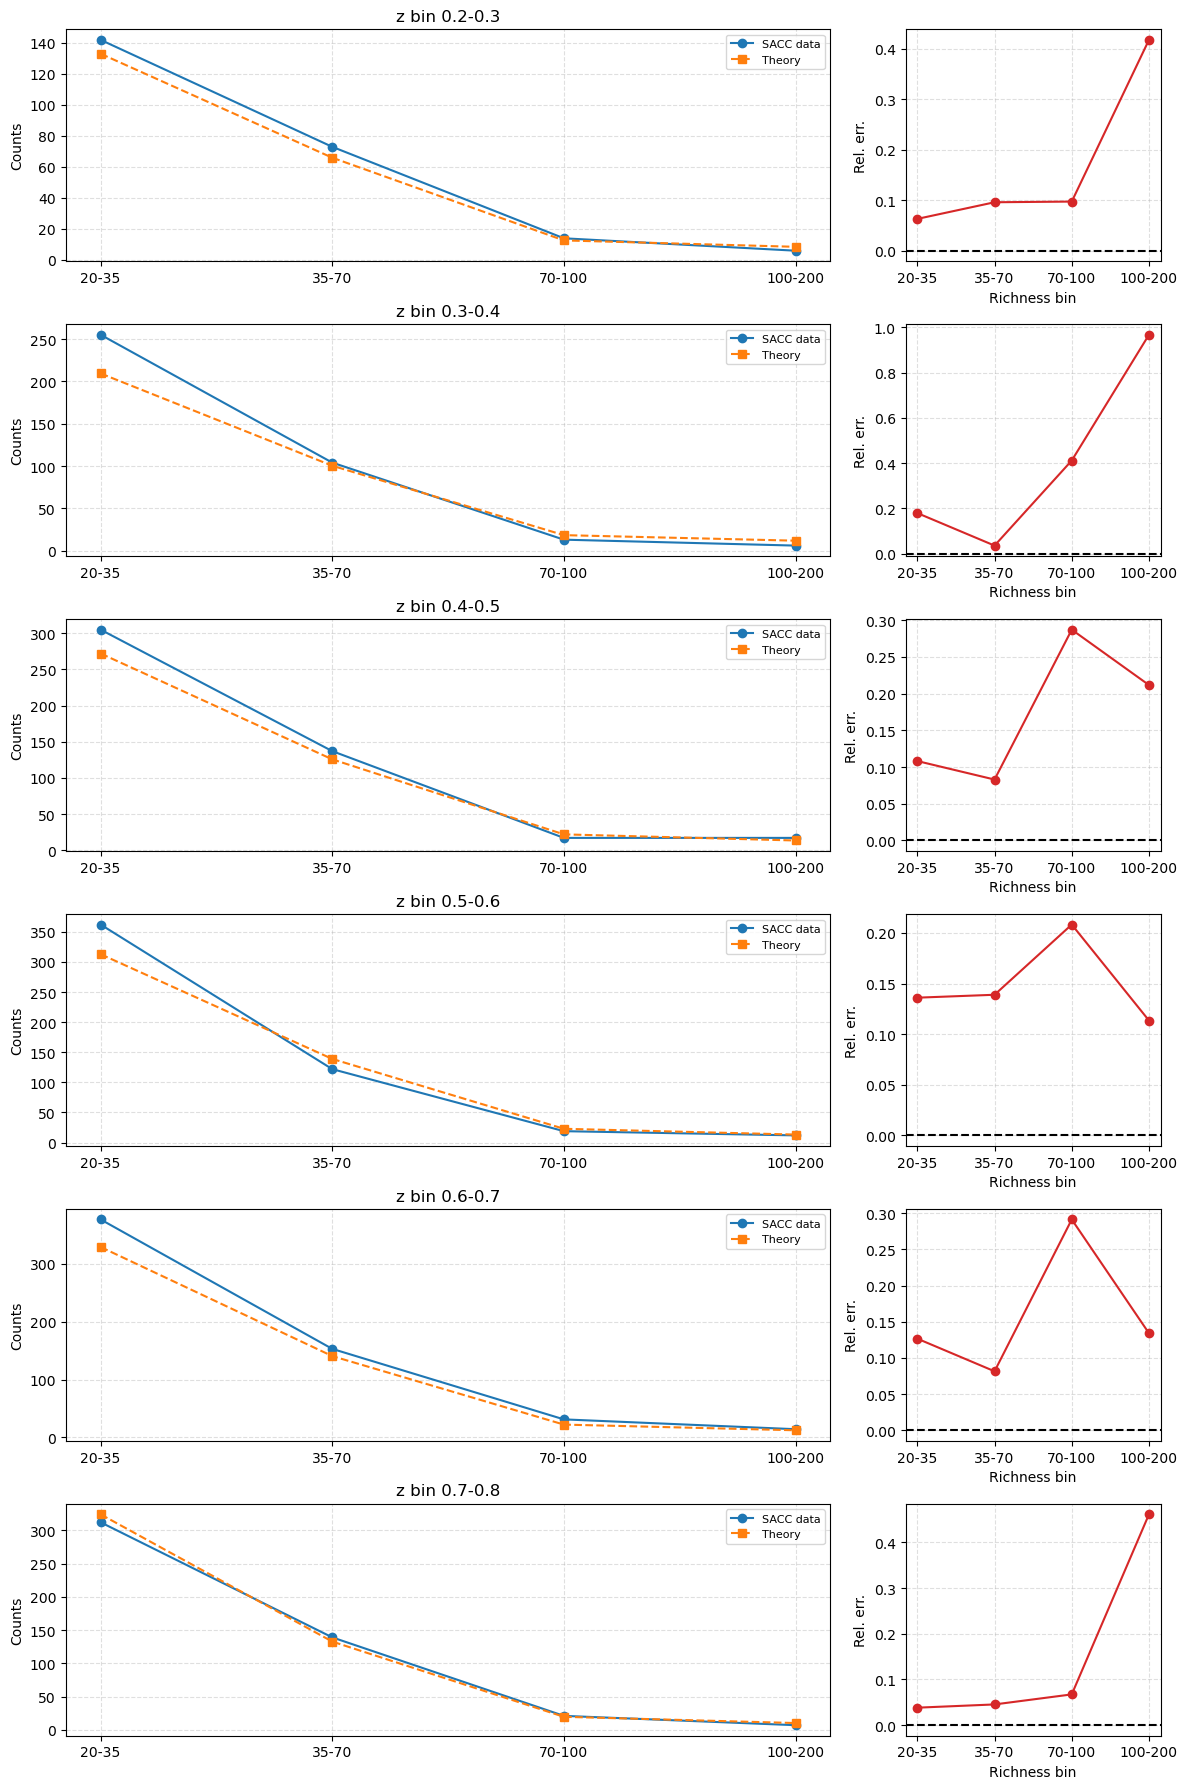

In [54]:
import matplotlib.pyplot as plt
import numpy as np

n_z, n_r = counts_data.shape

fig, axes = plt.subplots(n_z, 2, figsize=(12, 3*n_z), gridspec_kw={'width_ratios':[3,1]})
# axes[i,0] → data vs theory, axes[i,1] → relative error
if n_z == 1:
    axes = axes.reshape(1,2)

for i in range(n_z):
    # -------------------
    # Data vs Theory
    # -------------------
    ax_top = axes[i,0]
    ax_top.plot(
        np.arange(n_r),
        counts_data[i],
        marker='o',
        linestyle='-',
        label='SACC data'
    )
    ax_top.plot(
        np.arange(n_r),
        grid_counts_vals[i],
        marker='s',
        linestyle='--',
        label='Theory'
    )
    ax_top.set_ylabel("Counts")
    ax_top.set_title(f"z bin {z_bin_label[i]}")
    ax_top.legend(fontsize=8)
    ax_top.grid(True, ls="--", alpha=0.4)
    ax_top.set_xticks(np.arange(n_r))
    ax_top.set_xticklabels(rich_bin_label)


    # -------------------
    # Relative Error
    # -------------------
    ax_bot = axes[i,1]
    rel = np.abs(1 - grid_counts_vals[i] / counts_data[i])
    ax_bot.plot(
        np.arange(n_r),
        rel,
        marker='o',
        color='tab:red'
    )
    ax_bot.axhline(0, color='k', ls='--')
    ax_bot.set_ylabel("Rel. err.")
    ax_bot.set_xlabel("Richness bin")
    ax_bot.grid(True, ls="--", alpha=0.4)
    ax_bot.set_xticks(np.arange(n_r))
    ax_bot.set_xticklabels(rich_bin_label)
plt.tight_layout()
plt.show()

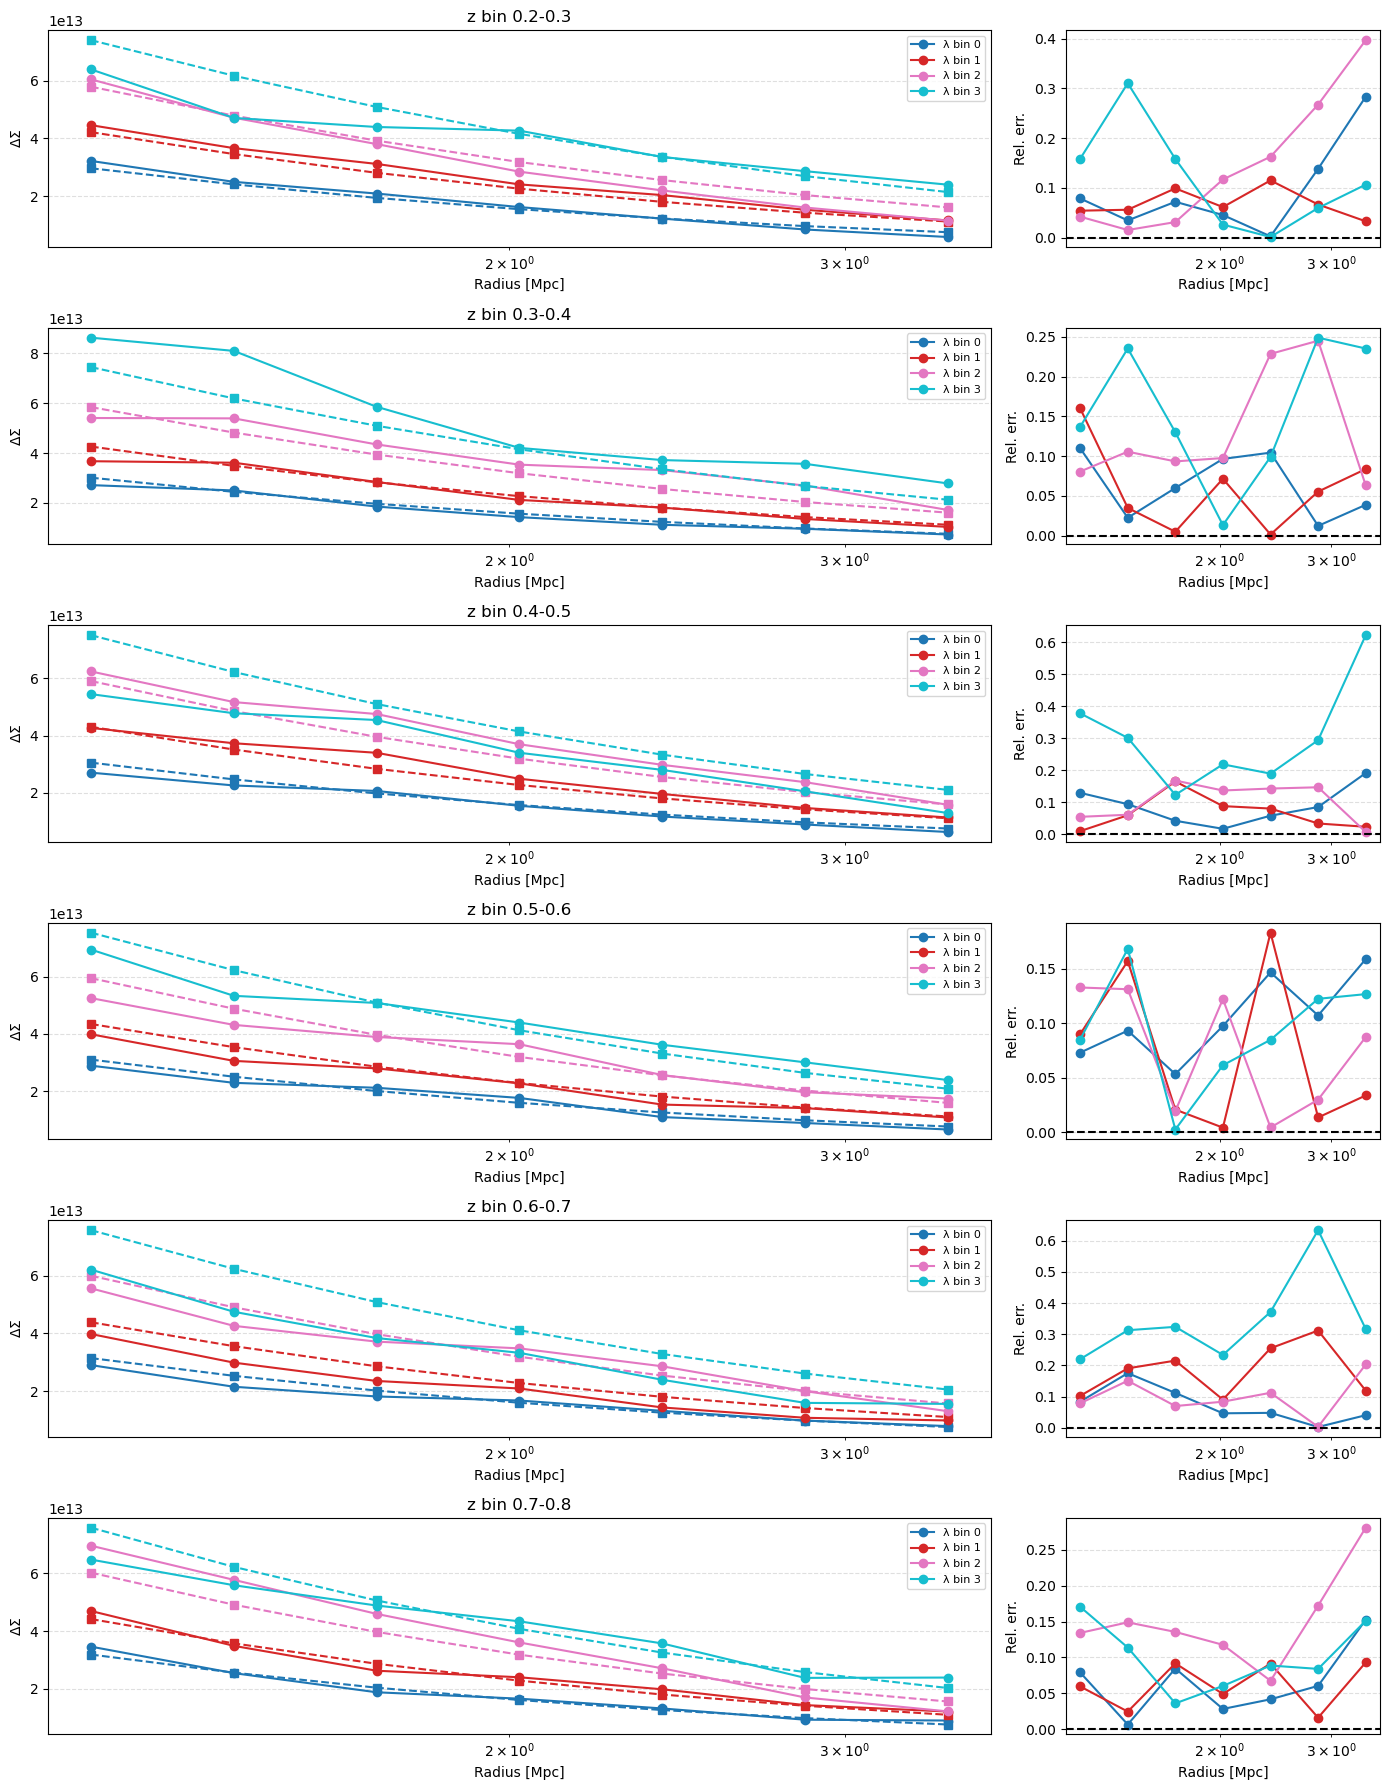

In [57]:
n_z, n_r, n_rad = shear_data.shape

fig, axes = plt.subplots(n_z, 2, figsize=(14, 3*n_z), gridspec_kw={'width_ratios':[3,1]})
if n_z == 1:
    axes = axes.reshape(1,2)

colors = plt.cm.tab10(np.linspace(0,1,n_r))

for i in range(n_z):
    ax_top = axes[i,0]
    ax_bot = axes[i,1]

    for j in range(n_r):
        # --- Top panel: data vs theory ---
        ax_top.plot(
            Radius_bins,
            shear_data[i,j],
            marker='o',
            linestyle='-',
            color=colors[j],
            label=f'λ bin {j}'
        )
        ax_top.plot(
            Radius_bins,
            grid_shear_vals[i,j],
            marker='s',
            linestyle='--',
            color=colors[j]
        )

        # --- Bottom panel: relative error ---
        rel = np.abs(1 - grid_shear_vals[i,j] / shear_data[i,j])
        ax_bot.plot(
            Radius_bins,
            rel,
            marker='o',
            color=colors[j]
        )

    ax_top.set_xscale('log')
    ax_top.set_ylabel(r'$\Delta\Sigma$')
    ax_top.set_title(f"z bin {z_bin_label[i]}")
    ax_top.grid(True, ls="--", alpha=0.4)
    ax_top.legend(fontsize=8)
    ax_top.set_xlabel("Radius [Mpc]")    
    ax_bot.set_xscale('log')
    ax_bot.axhline(0, color='k', ls='--')
    ax_bot.set_ylabel("Rel. err.")
    ax_bot.set_xlabel("Radius [Mpc]")
    ax_bot.grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()